In [1]:
import numpy as np
from env.map2d import *
from modules.bayesfilter import *
from scipy.stats import wasserstein_distance,entropy

In [2]:
class PredatorAndPrey(DecMap2d):
    def __init__(self,h,w,n_features=2,n_agents=1,_range=1):
        super().__init__(h,w,n_features,n_agents,_range)
        self.horizon = 30
        self.prey_policy = global_policy(self)
    def reset(self):
        self.t = 0
        self.prey_loc = np.random.randint(0,self.N,size=1).item()
        return super().reset()
    def get_obs(self):
        external = [self.within_range(pred,self.prey_loc,1) for pred in self.locs]
        return super().get_obs(), np.array(external,dtype=int)
    def step(self,action):
        self.t+=1
        obs = super().step(action)
        prey_action = self.prey_policy()
        self.prey_loc = np.random.choice(self.state_space,p=self.Pt[prey_action][self.prey_loc])
        reward = sum(obs[-1])
        done = self.t == self.horizon
        return self.get_obs(), reward, done, {}
    def render(self, agent=0, show_range=False):
        def get_color(x,y):
            if show_range:
                p = self.locs[agent]
                ay = p//self.w
                ax = p%self.w
                if self.chebyshev(x,y,ax,ay)<=1:
                    return [0,1,0]
            return cm.Greys(self.world[y*self.w+x]/self.n_features)[:3]
        def get_ccolor(x,y):
            if y*self.w+x == self.locs[agent]:
                return [1,0,0]
            elif y*self.w+x == self.prey_loc:
                return [1,0,1]
            elif y*self.w+x in self.locs:
                return [0,0,1]
            else:
                return None
        img = np.hstack([np.vstack([make_block(get_color(x,y),
                                               ccolor = get_ccolor(x,y))
                         for y in range(self.h)])
                        for x in range(self.w)])
        plt.imshow(img)
        plt.axis('off')
        plt.show()
        
def random_policy(env):
    return lambda: np.random.choice(env.control_space)

def global_policy(env):
    def f():
        avgloc = np.mean([env.translateLoc(x) for x in env.locs],0)
        target = np.subtract(env.translateLoc(env.prey_loc),avgloc).astype(int).clip(-1,1)
        return np.argwhere((env.actions==np.flip(target)).all(-1)).item()
    return f


In [3]:
def predator_policy(bel,env,epilson=0.5):
    controls = []
    locs = np.argwhere(bel==bel.max(-1).reshape(bel.shape[0],-1,1))
    ret = defaultdict(list)
    for i in locs:
        ret[tuple(i[:2])].append(i[-1])
        
    thetas = [np.exp(-entropy(b[-1])) for b in bel]
    for i in range(env.n_agents):
        maxlocs = [np.random.choice(ret[(i,j)]) for j in range(bel.shape[0])]
        
        avgLoc = np.mean([env.translateLoc(x) for x in maxlocs[:-1]],0)
        targetA = np.subtract(env.translateLoc(maxlocs[i]), avgLoc)
        
        targetB = np.subtract(env.translateLoc(maxlocs[-1]), env.translateLoc(maxlocs[i]))
        
        theta = thetas[i]
        target = (theta * targetB + (1-theta) * targetA).astype(int).clip(-1,1)
        controls.append(np.argwhere((env.actions==np.flip(target)).all(-1)).item())
    return controls

def random_ppolicy(bel,env):
    controls = []
    for i in range(env.n_agents):
        controls.append(np.random.choice(env.control_space))
    return controls

In [4]:
class DecMABayesFilter():
    def __init__(self, env, external = False):
        self.env = env
        self.n_agents = self.env.n_agents+1
        self.Pt = self.env.Pt
        self.Pz = self.env.Pz
        self.prey_Pz = np.array([[self.env.within_range(i*env.h+j,x)*1.
                                      for x in np.arange(0,self.env.h*self.env.w)]
                                     for j in range(self.env.w) for i in range(self.env.h)])
        self.bel = np.ones((self.n_agents-1,
                            self.n_agents, self.env.N))/self.env.N

    def mask_control(self, u):
        locs = self.env.locs.tolist() + [np.inf]
        return np.array([[self.Pt[_u if self.env.within(src,dest) else -1].transpose(1,0)
                          for dest,_u in zip(locs,u)]
                         for src in self.env.locs])
    
    def mask_measurement(self, z):
        return np.array([self.Pz(_z) for _z in z])
    
    def control_update(self, u):
        self.Pu = self.mask_control(u)
        self.bel_hat = np.einsum("bijk,bik->bij",self.Pu,self.bel)
        
    def measurement_update(self, z):
        for i, (src, bel_hat) in enumerate(zip(self.env.locs, self.bel_hat)):
            for j, (dest, bel_hat_i) in enumerate(zip(self.env.locs, bel_hat)):
                self.bel[i][j] = bel_hat_i * self.Pz(z[0][j] if self.env.within(src,dest) else -1)
                self.bel[i][j] /= sum(self.bel[i][j])
            
        for i, src in enumerate(self.env.locs):
            prey_Pz = self.prey_Pz
            if not z[1][i]:
                prey_Pz = 1 - prey_Pz
            prey_Pz /= sum(prey_Pz)
            Pz = np.matmul(prey_Pz.T,self.bel[i][-1])
            self.bel[i][-1] = self.bel_hat[i][-1] * Pz
            self.bel[i][-1] /= sum(self.bel[i][-1])
                
    def belief_sharing(self):
        from scipy.stats import entropy
        connected = [[j for j,dest in enumerate(self.env.locs) if self.env.within(src,dest)]
                     for i,src in enumerate(self.env.locs)]
        for i, agents in enumerate(connected):
            bel = np.array([self.bel[j].copy() for j in agents])
            ret = np.argmin(entropy(bel,axis=-1),axis=0)
            self.bel[i] = bel[ret,np.arange(self.n_agents)]

In [5]:
from scipy.stats import wasserstein_distance,entropy

def compute_WDc(env,agent):
    H = 0
    target = np.zeros(shape = (env.n_agents+1,env.N))
    target[np.arange(env.n_agents+1),env.locs.tolist() + [env.prey_loc]] = 1
    for bel in agent.bel:
        for u,v in zip(bel,target):
            H += wasserstein_distance(u, v)
    return H

def compute_WDp(env,agent):
    H = 0
    target = np.zeros(shape = (env.n_agents+1,env.N))
    target[np.arange(env.n_agents+1),env.locs.tolist() + [env.prey_loc]] = 1
    for bel in agent.bel:
        H += wasserstein_distance(bel[-1], target[-1])
    return H

from collections import defaultdict
def run(seed,policy,n_rounds=1,_range=1):
    np.random.seed(seed)
    score = defaultdict(list)
    h = 10
    w = 10
    env = PredatorAndPrey(h,w,n_agents=5,_range=_range)
    z = env.reset()
    agent = DecMABayesFilter(env)
    while True:
        u = policy(agent.bel,env)
        agent.control_update(u+[-1])
        z, reward, done,_  = env.step(u)
        agent.measurement_update(z)
        for i in range(n_rounds):
            agent.belief_sharing()
        score['reward'].append(reward)
        score['WD_cum'].append(compute_WDc(env,agent))
        score['WD_p'].append(compute_WDp(env,agent))
        
        if done:
            break
    return score

In [6]:
scores = defaultdict(dict)
for seed in range(100):
    for i in [0,1,5]:
        out = run(seed,predator_policy,i)
        for k,v in out.items():
            ret = scores['h'+str(i)].get(k,[])
            ret.append(v)
            scores['h'+str(i)][k] = ret
    for i in [0,1,5]:
        out = run(seed,random_ppolicy,i)
        for k,v in out.items():
            ret = scores['r'+str(i)].get(k,[])
            ret.append(v)
            scores['r'+str(i)][k] = ret
    out = run(seed,predator_policy,0,_range=10)
    for k,v in out.items():
        ret = scores['f0'].get(k,[])
        ret.append(v)
        scores['f0'][k] = ret

<>:36: DeprecationWarning: invalid escape sequence \m


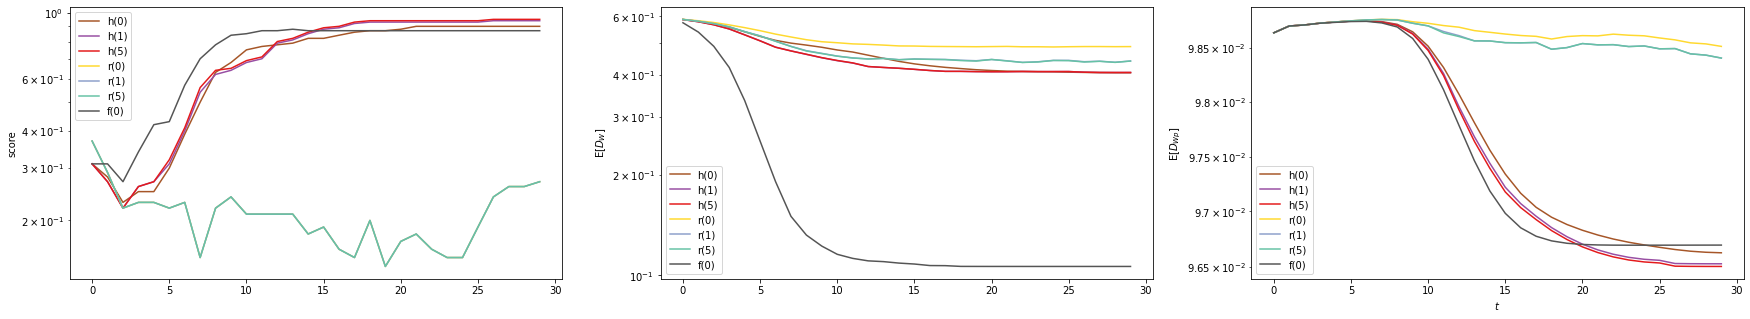

In [7]:
from matplotlib.cm import get_cmap
plt.figure(figsize=(30,5))

plt.subplot(131)
cmaps = ['Set1', 'Set2', 'binary']
for key in ['reward']:
    for i, agent in enumerate(scores.keys()):
        x = np.mean(scores[agent][key],0)
        if agent[0]=='h':
            cmap = get_cmap(cmaps[0])
        elif agent[0]=='r':
            cmap = get_cmap(cmaps[1])
        else:
            cmap = get_cmap(cmaps[2])
            
        plt.plot(x, color=cmap(((2-i)%3)/3), label=agent[0]+f"({agent[1]})")

plt.yscale('log')
plt.ylabel("score")
plt.legend()

plt.subplot(132)
cmaps = ['Set1', 'Set2', 'binary']
for key in ['WD_cum']:
    for i, agent in enumerate(scores.keys()):
        x = np.mean(scores[agent][key],0)
        if agent[0]=='h':
            cmap = get_cmap(cmaps[0])
        elif agent[0]=='r':
            cmap = get_cmap(cmaps[1])
        else:
            cmap = get_cmap(cmaps[2])
            
        plt.plot(x, color=cmap(((2-i)%3)/3), label=agent[0]+f"({agent[1]})")
plt.yscale('log')
plt.ylabel("$\mathrm{E}[D_W]$")
plt.legend()

plt.subplot(133)
cmaps = ['Set1', 'Set2', 'binary']
for key in ['WD_p']:
    for i, agent in enumerate(scores.keys()):
        x = np.mean(scores[agent][key],0)
        if agent[0]=='h':
            cmap = get_cmap(cmaps[0])
        elif agent[0]=='r':
            cmap = get_cmap(cmaps[1])
        else:
            cmap = get_cmap(cmaps[2])
            
        plt.plot(x, color=cmap(((2-i)%3)/3), label=agent[0]+f"({agent[1]})")
plt.yscale('log')
plt.ylabel("$\mathrm{E}[D_{Wp}]$")
plt.xlabel("$t$")
plt.legend()